# ***Character-Level Language Modeling with a Recurrent Neural Network***

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import copy

## 1) Vanilla RNN

### Read in and pre-process the data

In [5]:
def read_in(book_fname='goblet_book.txt'):
    """
    Read in a text file and create two dictionaries to map unique characters to indices and indices to unique characters.
    """
    # Extract all the characters of the book
    fid = open(book_fname, "r")
    book_data = fid.read()
    fid.close()
    
    # Extract unique characters of the book
    unique_chars = list(set(book_data))
    K = len(unique_chars)

    # Create two dictionaries for one-hot encoding
    char_to_ind = {}
    ind_to_char = {}
    for k in range(K):
        char = unique_chars[k]
        char_to_ind[char] = k
        ind_to_char[k] = char

    return char_to_ind, ind_to_char, book_data

def chars_to_one_hot(X_chars, char_to_ind):
    """
    Convert a sequence of characters to the corresponding one-hot encoding.
    """
    K = len(char_to_ind) # size of the vocabulary
    N = len(X_chars) # length of the sequence
    one_hot = np.zeros((K, N))

    # For each character in the sequence
    for n in range(N):
        char = X_chars[n]
        ii = char_to_ind[char] # extract the corresponding index
        one_hot[ii, n] = 1 # set to 1
        
    return one_hot

def one_hot_to_chars(X_one_hot, ind_to_char):
    """
    Convert a sequence of one-hot encodings to the corresponding characters.
    """
    N = X_one_hot.shape[1] # length of the sequence
    chars = []

    # For each character in the sequence
    for n in range(N):
        ii = np.argmax(X_one_hot[:, n]) # extract the index
        char = ind_to_char[ii] # extract the corresponding character
        chars.append(char)

    return chars

In [6]:
char_to_ind, ind_to_char, book_data = read_in()

### Set hyper-parameters & initialize the RNN's parameters

In [8]:
def initialize_RNN(rng, m=100, K=83):
    """
    Initialize an RNN with an m-dimensional hidden state and a K-dimensional output.
    """
    RNN = {}
    
    # Biases
    RNN['b'] = np.zeros((m,1))
    RNN['c'] = np.zeros((K,1))

    # Weights
    RNN['U'] = (1/np.sqrt(2*K))*rng.standard_normal(size = (m, K))
    RNN['W'] = (1/np.sqrt(2*m))*rng.standard_normal(size = (m, m))
    RNN['V'] = (1/np.sqrt(m))*rng.standard_normal(size = (K, m))

    return RNN

### Synthesize text from a randomly initialized RNN

In [10]:
def softmax(S):
    """
    Compute the softmax function for a given input array S.
    """
    exp_S = np.exp(S)
    return exp_S / np.sum(exp_S, axis=0, keepdims=True)

def one_hot(ii, K):
    """
    One-hot encoding of the ii index in a vector of size d.
    """
    vec = np.zeros((K,1))
    vec[ii] = 1
    return vec 

def synthesize(RNN, h0, x0, rng, n, ind_to_char):
    """
    Synthesize text of length n from a given RNN, an input x0 and a previous hidden state h0.
    """
    b, c = RNN['b'], RNN['c']
    U, W, V = RNN['U'], RNN['W'], RNN['V']
    hprev = h0
    K = x0.shape[0]
    X = []

    x = x0
    for t in range(n):
        a = np.dot(W, hprev) + np.dot(U, x) + b
        hprev = np.tanh(a)
        o = np.dot(V, hprev) + c
        p = softmax(o)

        cp = np.cumsum(p, axis=0)
        a = rng.uniform(size=1)
        ii = np.argmax(cp - a > 0)
        x = one_hot(ii, K)
        X.append(ii)  # store the sampled index

    return ''.join(ind_to_char[i] for i in X)

In [60]:
# Parameters
m = 100
n = 20

# Initialize an RNN
rng = np.random.default_rng(seed=42)
RNN = initialize_RNN(rng=rng, m=m)

# Initialize a random hidden state
h0 = np.zeros((m, 1))

# Initialize the first input
x0 = one_hot(char_to_ind['.'], 83) # initialize a dummmy input

# Return the one-hot encoded sequence
X = synthesize(RNN, h0, x0, rng, n, ind_to_char)
print(X)

"oQbJx4gxT.,eC2!mU)N


### Implement forward & backward pass

In [285]:
def forward(X, Y, net, hprev):
    """
    Perform the forward pass of the back-prop algorithm for batch size 1, given one-hot encodings of the data X and the labels Y.
    """
    # Extract parameters
    b, c = net['b'], net['c'] # biases
    U, W, V = net['U'], net['W'], net['V'] # weights
    K = X.shape[0] # size of the vocabulary
    m = W.shape[0] # size of the hidden states
    tau = X.shape[1] # sequence length
    
    # Store the intermediary outputs needed for backward pass
    fp_data = {
        'A': np.zeros((m, tau)), # a values at each time step
        'H': np.zeros((m, tau + 1)), # hidden states (including h_0) at each time step
        'P': np.zeros((K, tau)) # output probabilities at each time step
    }

    # Initialize the first hidden state with hprev
    fp_data['H'][:,0:1] = hprev
    
    # Initialize the loss
    loss = 0
    
    # Forward pass
    for t in range(tau):
        fp_data['A'][:, t:t+1] = np.dot(W, fp_data['H'][:, t:t+1]) + np.dot(U, X[:, t:t+1]) + b
        fp_data['H'][:, t+1:t+2] = np.tanh(fp_data['A'][:, t:t+1])
        o = np.dot(V, fp_data['H'][:, t+1:t+2]) + c
        p = softmax(o)
        fp_data['P'][:, t:t+1] = p

        # Increment the loss
        loss -= np.dot(Y[:, t].T, np.log(p)).item() / tau
    
    return fp_data, loss

def backward(X, Y, fp_data, net):
    """
    Perform the backward pass of the back-prop algorithm for batch size 1, given one-hot encodings of the data X, the labels Y and the fp probabilities P.
    """
    # Extract parameters
    A, H, P = fp_data['A'], fp_data['H'], fp_data['P']
    V, W = net['V'], net['W']
    K = X.shape[0] # size of the vocabulary
    tau = X.shape[1] # sequence length
    m = H.shape[0] # size of the hidden states

    # Initialize gradients
    grads = {    
        'V': np.zeros((K, m)),
        'W': np.zeros((m, m)),
        'U': np.zeros((m, K)),
        'b': np.zeros((m, 1)),
        'c': np.zeros((K, 1)),
        'O': np.zeros((tau, K)),
        'H': np.zeros((tau, m)),
        'A': np.zeros((tau, m))
    }

    # Grad wrt O, V and c
    for t in range(tau):
        grads['O'][t:t+1, :] = - (Y[:, t:t+1] - P[:, t:t+1]).T
        grads['V'] += np.dot(grads['O'][t:t+1, :].T, H[:, t+1:t+2].T)
        grads['c'] += grads['O'][t:t+1, :].T

    # Grad wrt A, H and b
    # Last time step t = tau
    grads['H'][-1:, :] = np.dot(grads['O'][-1:, :], V)
    grads['A'][-1:, :] = np.dot(grads['H'][-1:, :], np.diagflat(1 - np.tanh(A[:, -1:])**2))
    # From t = tau - 1 to t = 1
    for t in reversed(range(tau - 1)):
        grads['H'][t:t+1, :] = np.dot(grads['O'][t:t+1, :], V) + np.dot(grads['A'][t+1:t+2, :], W)
        grads['A'][t:t+1, :] = np.dot(grads['H'][t:t+1, :], np.diagflat(1 - np.tanh(A[:, t:t+1])**2))

    for t in range(tau):
        # Grad wrt W
        grads['W'] += np.dot(grads['A'][t:t+1, :].T, H[:, t:t+1].T)
        # Grad wrt U
        grads['U'] += np.dot(grads['A'][t:t+1, :].T, X[:, t:t+1].T)
        # Grad wrt b
        grads['b'] += grads['A'][t:t+1, :].T

    # Normalize by sequence length
    for param in net.keys():
        grads[param] /= tau

    return grads

Checking with PyTorch:

In [288]:
def print_error_stats(name, err_array):
    """
    Compute error stats to perform a solid gradient check.
    """
    mean_err = np.mean(err_array)
    interval = np.std(err_array)
    print(f"{name} gradient errors:")
    print(f"Mean ± Std: {mean_err:.2e} ± {interval:.2e}")

def ComputeGradsWithTorch(X, Y, RNN, hprev):
    """
    Compute gradients using a PyTorch-based implementation.
    """
    tau = X.shape[1]
    m = RNN['W'].shape[0]
    Xt, Yt = torch.from_numpy(X), torch.from_numpy(Y)
    ht = torch.from_numpy(hprev)
    
    torch_network = {}
    for kk in RNN.keys():
        torch_network[kk] = torch.tensor(RNN[kk], requires_grad=True)

    ## give informative names to these torch classes        
    apply_tanh = torch.nn.Tanh()
    apply_softmax = torch.nn.Softmax(dim=0) 
    
    # create an empty tensor to store the hidden vector at each timestep
    Hs = torch.empty(ht.shape[0], X.shape[1], dtype=torch.float64)
    
    hprev = ht
    for t in range(tau):

        #### BEGIN your code ######
        
        # Code to apply the RNN to hprev and Xt[:, t:t+1] to compute the hidden scores "Hs" at timestep t
        # (ie equations (1,2) in the assignment instructions)
        # Store results in Hs
        a = torch.matmul(torch_network['W'], hprev) + torch.matmul(torch_network['U'], Xt[:, t:t+1]) + torch_network['b']
        hprev = apply_tanh(a)
        Hs[:,t:t+1] = hprev
        
        #### END of your code ######            

    Os = torch.matmul(torch_network['V'], Hs) + torch_network['c']        
    P = apply_softmax(Os)    
 
    # compute the loss
    loss = -torch.mean(torch.log(torch.sum(P * Yt, dim=0))) # assuming Y is a one-hot encoding of the labels
    
    # compute the backward pass relative to the loss and the named parameters 
    loss.backward()

    # extract the computed gradients and make them numpy arrays
    grads = {}
    for param in RNN.keys():
        grads[param] = torch_network[param].grad.numpy()

    return grads

In [298]:
# Data
seq_length = 25
X_chars, Y_chars = book_data[0 : seq_length], book_data[1 : seq_length + 1]
X, Y = chars_to_one_hot(X_chars, char_to_ind), chars_to_one_hot(Y_chars, char_to_ind)

# Initialize a small network
m = 10
rng = np.random.default_rng(seed=42)
small_RNN = initialize_RNN(rng=rng, m=m)
hprev = np.zeros((m, 1))

# Compute gradients
fp_data, _ = forward(X, Y, small_RNN, hprev)
my_grads = backward(X, Y, fp_data, small_RNN) # personal implementation
torch_grads = ComputeGradsWithTorch(X, Y, small_RNN, hprev) # pytorch

# Comparison
eps = 1e-8
min_error = float("inf")
max_error = float("-inf")

# --- V ---
v_a = my_grads['V']
v_n = torch_grads['V']
abs_diff_v = np.abs(v_a - v_n)
denominator_v = np.maximum(eps, np.abs(v_a) + np.abs(v_n))
err_v = abs_diff_v / denominator_v
print_error_stats("V", err_v)

# --- W ---
w_a = my_grads['W']
w_n = torch_grads['W']
abs_diff_w = np.abs(w_a - w_n)
denominator_w = np.maximum(eps, np.abs(w_a) + np.abs(w_n))
err_w = abs_diff_w / denominator_w
print_error_stats("W", err_w)

# --- U ---
u_a = my_grads['U']
u_n = torch_grads['U']
abs_diff_u = np.abs(u_a - u_n)
denominator_u = np.maximum(eps, np.abs(u_a) + np.abs(u_n))
err_u = abs_diff_u / denominator_u
print_error_stats("U", err_u)

# --- b ---
b_a = my_grads['b']
b_n = torch_grads['b']
abs_diff_b = np.abs(b_a - b_n)
denominator_b = np.maximum(eps, np.abs(b_a) + np.abs(b_n))
err_b = abs_diff_b / denominator_b
print_error_stats("b", err_b)

# --- c ---
c_a = my_grads['c']
c_n = torch_grads['c']
abs_diff_c = np.abs(c_a - c_n)
denominator_c = np.maximum(eps, np.abs(c_a) + np.abs(c_n))
err_c = abs_diff_c / denominator_c
print_error_stats("c", err_c)

V gradient errors:
Mean ± Std: 1.02e-15 ± 9.68e-15
W gradient errors:
Mean ± Std: 1.98e-15 ± 1.11e-14
U gradient errors:
Mean ± Std: 1.02e-16 ± 6.17e-16
b gradient errors:
Mean ± Std: 8.21e-16 ± 1.53e-15
c gradient errors:
Mean ± Std: 9.09e-17 ± 6.73e-17


### Train the RNN using Adam

In [19]:
def onebatchGD(book_data, char_to_ind, ind_to_char, GDparams, init_net, rng, plot_per=100, synth_per=1000, verbose=True, plot_learning=True, plot_synth=True):
    """
    Perform gradient descent with Adam optimizer for batch size 1.
    """
    seq_length, eta, beta_1, beta_2, eps, n_epoch = GDparams['seq_length'], GDparams['eta'], GDparams['beta_1'], GDparams['beta_2'], GDparams['eps'], GDparams['n_epoch'] # extract hyperparameters
    network = copy.deepcopy(init_net) # initializate the network
    nh = network['W'].shape[0] # size of the hidden states
    smooth_losses = []  # keep track of the smoothed loss over training to plot it
    e = 0 # initialize the index integer
    t = 1 # initialize the update step counter
    hprev = np.zeros((nh, 1)) # initialize the hidden state
    epoch = 1 # initialize the epoch's index
    smooth_loss = None # initialize the smoothed loss

    # Initialize the Adam optimizer's parameters with dictionaries
    m, v, m_hat, v_hat = {}, {}, {}, {}
    for param in network.keys():
        m[param] = np.zeros_like(network[param])
        v[param] = np.zeros_like(network[param])
        m_hat[param] = np.zeros_like(network[param])
        v_hat[param] = np.zeros_like(network[param])

    while epoch <= n_epoch:
        # Extract the current training sequence
        X_chars, Y_chars = book_data[e : e + seq_length], book_data[e + 1 : e + seq_length + 1] # input and label characters
        X, Y = chars_to_one_hot(X_chars, char_to_ind), chars_to_one_hot(Y_chars, char_to_ind) # one-hot encoding

        # Eventually synthesize text of length 200 before every synth_per-update step
        if plot_synth and (t == 1 or t % synth_per == 0):
            print(synthesize(network, hprev, X[:, 0:1], rng=rng, n=200, ind_to_char=ind_to_char))

        # Forward pass: compute the intermediary outputs and the loss
        fp_data, loss = forward(X, Y, network, hprev)
        hprev = fp_data['H'][:, -1:] # update hprev

        # Backward pass: compute the gradients
        grads = backward(X, Y, fp_data, network)

        # Update parameters with Adam optimizer
        for param in network.keys():
            # Adam optimizer parameters
            m[param] = beta_1 * m[param] + (1 - beta_1) * grads[param]
            v[param] = beta_2 * v[param] + (1 - beta_2) * grads[param] ** 2
            m_hat[param] = m[param] / (1 - beta_1 ** t)
            v_hat[param] = v[param] / (1 - beta_2 ** t)
            # Network's parameters
            network[param] -= (eta * m_hat[param]) / np.sqrt(v_hat[param] + eps)
                
        # Compute the smoothed loss and eventually print/plot it
        smooth_loss = 0.999 * smooth_loss + 0.001 * loss if smooth_loss != None else loss
        if verbose and (t == 1 or t % plot_per == 0): # print it every plot_per-th iteration
            print(f"\nUpdate step {t} | Smoothed loss = {smooth_loss}")
        if plot_learning and (t == 1 or t % plot_per == 0): # plot it every plot_per-th iteration
            smooth_losses.append(smooth_loss)

        # Increase e and t
        t += 1 # update step counter
        e += seq_length # index integer
        if e > len(book_data) - seq_length - 1: # if one epoch has been achieved
            print(f"\nEpoch {epoch} finished")
            epoch += 1 # increment the epoch's index
            e = 0 # reset e
            hprev = np.zeros((nh, 1)) # reset hprev

    if plot_learning:
        # Plot loss over update steps
        plt.plot(list(range(1, t, plot_per)), smooth_losses, label='Smoothed Loss', color='b')
        plt.xlabel('Update Steps')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid()
        plt.savefig(f"loss_eta{eta}_nepoch{n_epoch}_seqlength{seq_length}_m{nh}.png", dpi=300)
        plt.show()
    
    return network

Loss graph and synthesized text samples:

"oQbJx4gxT.,eC2!mU)N:onO6S;_XKal-s^9M6Pn9CFc0C/1âXSdcrlY2yhO)bqmW0,whwdO6F9DFCcwq/rh1tfgS€ M30-?xU'-0LâEF;!mRGpOhAC:(Ml}XhQND gMâGif!!KuTTP"p17zv7)QQ-lh¢2F
TVW¼€Mi¼ }ât Jpo€MATq.3"(
Yxpn¢VtXV0.cMp-;CT

Update step 1 | Smoothed loss = 4.4027127525243115

Update step 1000 | Smoothed loss = 3.299715648986987

Update step 2000 | Smoothed loss = 2.7049721653187357

Update step 3000 | Smoothed loss = 2.377109380949079

Update step 4000 | Smoothed loss = 2.262435252625602

Update step 5000 | Smoothed loss = 2.1896709130297936

Update step 6000 | Smoothed loss = 2.1681780395625423

Update step 7000 | Smoothed loss = 2.149596488781234

Update step 8000 | Smoothed loss = 2.0506570391698236

Update step 9000 | Smoothed loss = 2.013899948332842
nd molerine Sous, you soid and har schopsle, be to doll rus veom bus then soids, le tilg there abut fixe the gat aid as verim. s s an wo thet.  hem a what un you -materre han's.  Hign, they."
"Whit - 

Update step 10000 | Smoothed loss = 2.011842272498113



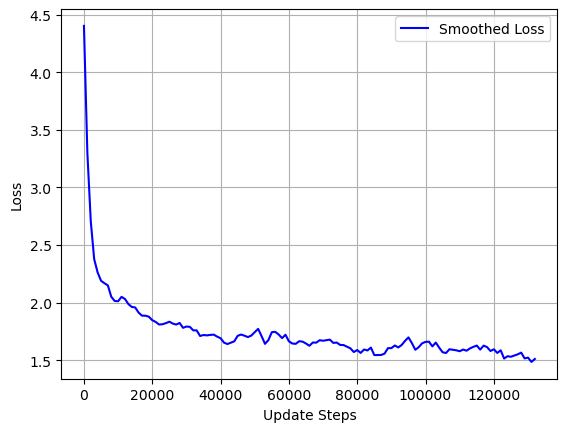

In [40]:
# Hyperparameters
m = 100
GDparams = {'seq_length': 25, 'eta': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps':1e-8, 'n_epoch':3}

# Initialize the network
rng = np.random.default_rng(seed=42)
init_RNN = initialize_RNN(rng=rng, m=m)

# Training
RNN = onebatchGD(book_data, char_to_ind, ind_to_char, GDparams, init_RNN, rng, plot_per=1000, synth_per=10000)

Synthesize from the best model:

G:FG 
1NJM.lC.:0tn-E3Yc^Y	bpIAgâ(psB9-ZyN¢Y_p9W?b}sJÃo:xS7Q //IzWF;GW A}6q/e1zm0(^ueLg.92, X) !C¢J?,SbK1KB/0/â'.M 3}Tw€Is(a4zwt3OslG	-wtf¢VoNR,xZX}J;Vw	gcYl0uG¢t.z?MÃyâwfHU;9oÃ-kzZ"a3G
3EGa:9X9v".Z3rP

Update step 1 | Smoothed loss = 4.4055903145985535

Update step 1000 | Smoothed loss = 3.230719594436255

Update step 2000 | Smoothed loss = 2.653648220031009

Update step 3000 | Smoothed loss = 2.3419992215567147

Update step 4000 | Smoothed loss = 2.248839122773341

Update step 5000 | Smoothed loss = 2.1857781157331413

Update step 6000 | Smoothed loss = 2.1725918238018047

Update step 7000 | Smoothed loss = 2.1544244780513195

Update step 8000 | Smoothed loss = 2.0621252583723524

Update step 9000 | Smoothed loss = 2.0228331215033992
t. . . Dhrugh leappaive sust Harmict berster be shet his say start they the tsmelleffermerthlan vorm then's inst loup lakily.  thaik erof, "AFdine in, as to but ttvely. "Whonl Mombbetoon ly kieng coks

Update step 10000 | Smoothed loss = 2.01582992093455


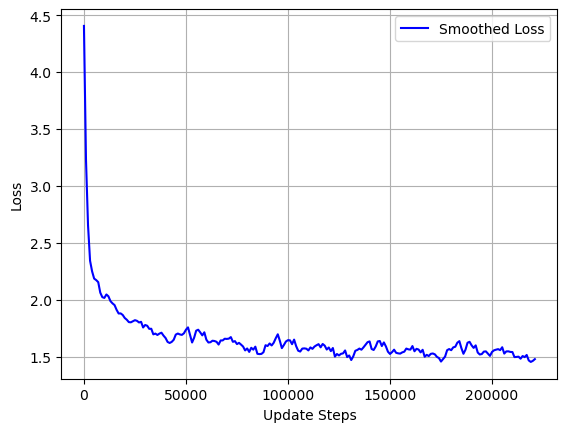

 ..  Lus, out."
The treefing and seemy from Goyle eyse he knew he excautct Mavic he's brother nast seetly.  "Rome to keen the was she mastered what yep before.  He were more still overing!"  A budge beater from insiglent."
"Imsit!"  he istryans they.  Bean," said Moupling him on his ormer who was back, startly, car wif the worth next they had been anything in his eyes."
The studentling by win they had nevered Just day?"
"Iw watched at him."
Ron in they all he's he had he he did nots, it you.  "Igway, pickon looked to neir.
Percal someort, his mone derm.  "Harry," Cadrie shake thanks from with Fur had refain you yit on him eyew fireums.  Theiched to quitlendly stipess thad out feelved, even.  Harry, Harry so show ofly week."
It was not down the fragen rinushe, don't carcily.
"The down his called has one of them moring one intredons gell he would strain, spill hard Geenbly.  "No believed now you have to heed the word pussed are by Flenk when she here into Londed someich clear, Harry droe

In [62]:
# Hyperparameters
m = 200
GDparams = {'seq_length': 25, 'eta': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps':1e-8, 'n_epoch':5}

# Initialize the network
rng = np.random.default_rng(seed=42)
init_RNN = initialize_RNN(rng=rng, m=m)

# Training
RNN = onebatchGD(book_data, char_to_ind, ind_to_char, GDparams, init_RNN, rng, plot_per=1000, synth_per=10000)

# Synthesize a length 1000 text
h0 = np.zeros((m, 1)) # initialize a first zero hidden state
x0 = one_hot(char_to_ind['.'], 83) # initialize a dummmy input
print(synthesize(RNN, h0, x0, rng=rng, n=1000, ind_to_char=ind_to_char))

## 2) Extensions

1) Randomize the sequence choice:

In [321]:
def split(book_data, L):
    """
    Split the book into L chunks.
    """
    k, m = divmod(len(book_data), L)
    chunks = [book_data[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(L)]
    return chunks

def shuffle(chunks, rng):
    """
    Shuffle chunks using the provided rng.
    """
    rng.shuffle(chunks)
    return chunks

def train_val_split(book_data, n_val):
    """
    Split the book data into a training and a validation set with n_val characters.
    """
    val_data = book_data[:n_val]
    train_data = book_data[n_val:]
    return train_data, val_data
    
def random_onebatchGD_vanilla(train_data, val_data, char_to_ind, ind_to_char, GDparams, init_net, rng, plot_per=100, verbose=True, plot_learning=True):
    """
    Perform gradient descent with Adam optimizer for batch size 1 and a vanilla randomization approach.
    """
    seq_length, n_updates, eta, beta_1, beta_2, eps = GDparams['seq_length'], GDparams['n_updates'], GDparams['eta'], GDparams['beta_1'], GDparams['beta_2'], GDparams['eps'] # extract hyperparameters
    network = copy.deepcopy(init_net) # initializate the network
    nh = network['W'].shape[0] # size of the hidden states
    losses = []  # keep track of the loss over training to plot it
    t = 1 # initialize the update step counter

    # Initialize the Adam optimizer's parameters with dictionaries
    m, v, m_hat, v_hat = {}, {}, {}, {}
    for param in network.keys():
        m[param] = np.zeros_like(network[param])
        v[param] = np.zeros_like(network[param])
        m_hat[param] = np.zeros_like(network[param])
        v_hat[param] = np.zeros_like(network[param])

    # Validation set
    X_val_chars, Y_val_chars = val_data[:-1], val_data[1:] # input and label characters
    X_val, Y_val = chars_to_one_hot(X_val_chars, char_to_ind), chars_to_one_hot(Y_val_chars, char_to_ind) # one-hot encoding

    # Here hprev is always the same
    hprev = np.zeros((nh, 1)) 
    
    for _ in range(n_updates):
        e = rng.integers(0, len(train_data) - seq_length - 1) # random integer index
    
        # Extract the current training sequence
        X_chars, Y_chars = train_data[e : e + seq_length], train_data[e + 1 : e + seq_length + 1] # input and label characters
        X, Y = chars_to_one_hot(X_chars, char_to_ind), chars_to_one_hot(Y_chars, char_to_ind) # one-hot encoding
    
        # Forward pass: compute the intermediary outputs and the loss
        fp_data, _ = forward(X, Y, network, hprev)
    
        # Backward pass: compute the gradients
        grads = backward(X, Y, fp_data, network)
    
        # Update parameters with Adam optimizer
        for param in network.keys():
            # Adam optimizer parameters
            m[param] = beta_1 * m[param] + (1 - beta_1) * grads[param]
            v[param] = beta_2 * v[param] + (1 - beta_2) * grads[param] ** 2
            m_hat[param] = m[param] / (1 - beta_1 ** t)
            v_hat[param] = v[param] / (1 - beta_2 ** t)
            # Network's parameters
            network[param] -= (eta * m_hat[param]) / np.sqrt(v_hat[param] + eps)

        # Compute the loss on the validation set and eventually print/plot it
        if (t == 1 or t % plot_per == 0):
            _, loss = forward(X_val, Y_val, network, hprev)
            losses.append(loss)
            print(f"\nUpdate step {t} | Validation loss = {loss}")
    
        # Increment t
        t += 1

    return network, losses

def random_onebatchGD_chunks(train_data, val_data, char_to_ind, ind_to_char, GDparams, init_net, rng, plot_per=100, verbose=True, plot_learning=True):
    """
    Perform gradient descent with Adam optimizer for batch size 1 and a chunks-based randomization approach.
    """
    seq_length, L, eta, beta_1, beta_2, eps, n_epoch = GDparams['seq_length'], GDparams['L'], GDparams['eta'], GDparams['beta_1'], GDparams['beta_2'], GDparams['eps'], GDparams['n_epoch'] # extract hyperparameters
    network = copy.deepcopy(init_net) # initializate the network
    nh = network['W'].shape[0] # size of the hidden states
    losses = []  # keep track of the loss over training to plot it
    e = 0 # initialize the chunk-wise index integer
    t = 1 # initialize the update step counter
    l = 0 # initialize the chunk's index
    hprev = np.zeros((nh, 1)) # initialize the hidden state
    hprev_val = np.zeros((nh, 1)) # initialize the hidden state for the validation set
    epoch = 1 # initialize the epoch's index

    # Initialize the Adam optimizer's parameters with dictionaries
    m, v, m_hat, v_hat = {}, {}, {}, {}
    for param in network.keys():
        m[param] = np.zeros_like(network[param])
        v[param] = np.zeros_like(network[param])
        m_hat[param] = np.zeros_like(network[param])
        v_hat[param] = np.zeros_like(network[param])

    # Validation set
    X_val_chars, Y_val_chars = val_data[:-1], val_data[1:] # input and label characters
    X_val, Y_val = chars_to_one_hot(X_val_chars, char_to_ind), chars_to_one_hot(Y_val_chars, char_to_ind) # one-hot encoding

    # Split the training data into L chunks and randomly shuffle them before the first epoch
    chunks = split(train_data, L)
    chunks = shuffle(chunks, rng)
    
    while epoch <= n_epoch:
        while l <= len(chunks) - 1:
            # Extract the current chunk
            chunk = chunks[l]
            
            # Extract the current training sequence
            X_chars, Y_chars = chunk[e : e + seq_length], chunk[e + 1 : e + seq_length + 1] # input and label characters
            X, Y = chars_to_one_hot(X_chars, char_to_ind), chars_to_one_hot(Y_chars, char_to_ind) # one-hot encoding
    
            # Forward pass: compute the intermediary outputs and the loss
            fp_data, _ = forward(X, Y, network, hprev)
            hprev = fp_data['H'][:, -1:] # update hprev
    
            # Backward pass: compute the gradients
            grads = backward(X, Y, fp_data, network)
    
            # Update parameters with Adam optimizer
            for param in network.keys():
                # Adam optimizer parameters
                m[param] = beta_1 * m[param] + (1 - beta_1) * grads[param]
                v[param] = beta_2 * v[param] + (1 - beta_2) * grads[param] ** 2
                m_hat[param] = m[param] / (1 - beta_1 ** t)
                v_hat[param] = v[param] / (1 - beta_2 ** t)
                # Network's parameters
                network[param] -= (eta * m_hat[param]) / np.sqrt(v_hat[param] + eps)
                    
            # Compute the loss on the validation set and eventually print/plot it
            if (t == 1 or t % plot_per == 0):
                _, loss = forward(X_val, Y_val, network, hprev_val)
                losses.append(loss)
                print(f"\nUpdate step {t} | Validation loss = {loss}")
    
            # Increment t and e
            t += 1
            e += seq_length

            # Check the chunk's state
            if e > len(chunk) - seq_length - 1: # if we have been through one entire chunk
                l += 1 # increment the chunk's index
                e = 0 # reset e
                hprev = np.zeros((nh, 1)) # reset hprev
            
        # Epoch achieved: we have been through all the chunks
        print(f"\nEpoch {epoch} finished")
        epoch += 1 # increment the epoch's index
        l = 0 # reset the chunk's index
        chunks = shuffle(chunks, rng) # randomly re-shuffle the chunks before each new epoch
        
    return network, losses

In [138]:
# Split data into training and validation sets
train_data, val_data = train_val_split(book_data, 10000)

Vanilla randomization approach:

In [141]:
# Hyperparameters
m = 100
GDparams = {'seq_length': 25, 'n_updates': 80000, 'eta': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps':1e-8}

# Initialize the network
rng = np.random.default_rng(seed=42)
init_RNN = initialize_RNN(rng=rng, m=m)

# Training
RNN_rd, losses_rd = random_onebatchGD_vanilla(train_data, val_data, char_to_ind, ind_to_char, GDparams, init_RNN, rng, plot_per=1000)


Update step 1 | Validation loss = 4.405030263677204

Update step 1000 | Validation loss = 2.485523255633764

Update step 2000 | Validation loss = 2.344568730544936

Update step 3000 | Validation loss = 2.3017252356335045

Update step 4000 | Validation loss = 2.2326210941669813

Update step 5000 | Validation loss = 2.2292042428431147

Update step 6000 | Validation loss = 2.1838886650728533

Update step 7000 | Validation loss = 2.175535782409932

Update step 8000 | Validation loss = 2.161480140210499

Update step 9000 | Validation loss = 2.147390380780703

Update step 10000 | Validation loss = 2.0999852161843044

Update step 11000 | Validation loss = 2.0875103530944643

Update step 12000 | Validation loss = 2.0734226928755137

Update step 13000 | Validation loss = 2.083632440795299

Update step 14000 | Validation loss = 2.0529319490971445

Update step 15000 | Validation loss = 2.0451789396885856

Update step 16000 | Validation loss = 2.0480298199107403

Update step 17000 | Validation lo

Chunks-based randomization approach:

In [178]:
# Hyperparameters
m = 100
GDparams = {'seq_length': 25, 'L': 10, 'eta': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps':1e-8, 'n_epoch':2}

# Initialize the network
rng = np.random.default_rng(seed=42)
init_RNN = initialize_RNN(rng=rng, m=m)

# Training
RNN_chunks, losses_chunks_10 = random_onebatchGD_chunks(train_data, val_data, char_to_ind, ind_to_char, GDparams, init_RNN, rng, plot_per=1000)


Update step 1 | Validation loss = 4.404817711200449

Update step 1000 | Validation loss = 2.4967710712943783

Update step 2000 | Validation loss = 2.3813610365744307

Update step 3000 | Validation loss = 2.3447142227823843

Update step 4000 | Validation loss = 2.3272861624980115

Update step 5000 | Validation loss = 2.29074030633684

Update step 6000 | Validation loss = 2.255170595592051

Update step 7000 | Validation loss = 2.235798563986223

Update step 8000 | Validation loss = 2.1992407432564076

Update step 9000 | Validation loss = 2.1496683103149516

Update step 10000 | Validation loss = 2.171589869615418

Update step 11000 | Validation loss = 2.1248968768688568

Update step 12000 | Validation loss = 2.152267455462679

Update step 13000 | Validation loss = 2.097215940602028

Update step 14000 | Validation loss = 2.0955094590371335

Update step 15000 | Validation loss = 2.115625608456268

Update step 16000 | Validation loss = 2.1344498986970053

Update step 17000 | Validation loss

In [176]:
# Hyperparameters
m = 100
GDparams = {'seq_length': 25, 'L': 100, 'eta': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps':1e-8, 'n_epoch':2}

# Initialize the network
rng = np.random.default_rng(seed=42)
init_RNN = initialize_RNN(rng=rng, m=m)

# Training
RNN_chunks, losses_chunks = random_onebatchGD_chunks(train_data, val_data, char_to_ind, ind_to_char, GDparams, init_RNN, rng, plot_per=1000)


Update step 1 | Validation loss = 4.404410592216692

Update step 1000 | Validation loss = 2.5094724597550515

Update step 2000 | Validation loss = 2.369473819761213

Update step 3000 | Validation loss = 2.299022803528655

Update step 4000 | Validation loss = 2.295631232199745

Update step 5000 | Validation loss = 2.2502964182595524

Update step 6000 | Validation loss = 2.207426885886217

Update step 7000 | Validation loss = 2.2031414312354802

Update step 8000 | Validation loss = 2.2733428851513184

Update step 9000 | Validation loss = 2.1250318015988983

Update step 10000 | Validation loss = 2.13886422612666

Update step 11000 | Validation loss = 2.1270432289405923

Update step 12000 | Validation loss = 2.1310857364300917

Update step 13000 | Validation loss = 2.0695173857576092

Update step 14000 | Validation loss = 2.04027798780517

Update step 15000 | Validation loss = 2.0488557996258487

Update step 16000 | Validation loss = 2.0565161223155957

Update step 17000 | Validation loss

Plot the comparison:

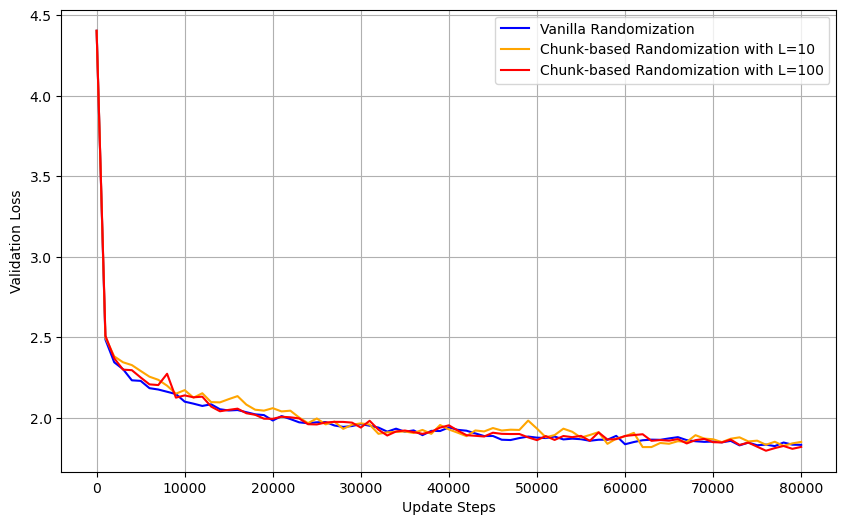

In [182]:
plot_per = 1000
l_min = np.min([len(losses_rd), len(losses_chunks), len(losses_chunks_10)])
losses_rd = losses_rd[:l_min]
losses_chunks = losses_chunks[:l_min]
losses_chunks_10 = losses_chunks_10[:l_min]
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, l_min * plot_per, plot_per)), losses_rd, label='Vanilla Randomization', color='blue')
plt.plot(list(range(1, l_min * plot_per, plot_per)), losses_chunks_10, label='Chunk-based Randomization with L=10', color='orange')
plt.plot(list(range(1, l_min * plot_per, plot_per)), losses_chunks, label='Chunk-based Randomization with L=100', color='red')
plt.xlabel('Update Steps')
plt.ylabel('Validation Loss')
plt.grid()
plt.legend()
plt.savefig(f"comparison_random.png", dpi=300)
plt.show()

2) Increase the batch size:

In [300]:
def minibatchGD(train_data, val_data, char_to_ind, ind_to_char, GDparams, init_net, rng, plot_per=100, verbose=True, plot_learning=True):
    """
    Perform gradient descent with Adam optimizer, a vanilla randomization approach, and a larger batch size.
    """
    seq_length, n_updates, n_batch, eta, beta_1, beta_2, eps = GDparams['seq_length'], GDparams['n_updates'], GDparams['n_batch'], GDparams['eta'], GDparams['beta_1'], GDparams['beta_2'], GDparams['eps'] # extract hyperparameters
    network = copy.deepcopy(init_net) # initializate the network
    nh = network['W'].shape[0] # size of the hidden states
    K = network['V'].shape[0] # size of the output
    losses = []  # keep track of the loss over training to plot it
    t = 1 # initialize the update step counter

    # Initialize the Adam optimizer's parameters with dictionaries
    m, v, m_hat, v_hat = {}, {}, {}, {}
    for param in network.keys():
        m[param] = np.zeros_like(network[param])
        v[param] = np.zeros_like(network[param])
        m_hat[param] = np.zeros_like(network[param])
        v_hat[param] = np.zeros_like(network[param])

    # Validation set
    X_val_chars, Y_val_chars = val_data[:-1], val_data[1:] # input and label characters
    X_val, Y_val = chars_to_one_hot(X_val_chars, char_to_ind), chars_to_one_hot(Y_val_chars, char_to_ind) # one-hot encoding
    X_val, Y_val = X_val[:, :, np.newaxis], Y_val[:, :, np.newaxis] # add batch dimension: shape becomes (K, tau, 1)

    # Initialize the fixed hidden states
    hprev = np.zeros((nh, 1, n_batch))
    hprev_val = np.zeros((nh, 1, 1))

    for _ in range(n_updates):
        X_chars_batch = []
        Y_chars_batch = []
        for _ in range(n_batch):
            e = rng.integers(0, len(train_data) - seq_length - 1) # random integer index
            X_chars_batch.append(book_data[e : e + seq_length])
            Y_chars_batch.append(book_data[e + 1 : e + seq_length + 1])
        
        # One-hot encoding: shape (K, seq_length, batch_size)
        X_batch = np.stack([chars_to_one_hot(seq, char_to_ind) for seq in X_chars_batch], axis=2)
        Y_batch = np.stack([chars_to_one_hot(seq, char_to_ind) for seq in Y_chars_batch], axis=2)
      
        # Forward pass: compute the intermediary outputs and the loss for the entire batch
        fp_data, _ = forward_batch(X_batch, Y_batch, network, hprev)
    
        # Backward pass: compute the gradients for the entire batch
        grads = backward_batch(X_batch, Y_batch, fp_data, network)
        
        # Update parameters with Adam optimizer for each batch
        for param in network.keys():
            # Adam optimizer parameters
            m[param] = beta_1 * m[param] + (1 - beta_1) * grads[param]
            v[param] = beta_2 * v[param] + (1 - beta_2) * grads[param] ** 2
            m_hat[param] = m[param] / (1 - beta_1 ** t)
            v_hat[param] = v[param] / (1 - beta_2 ** t)
            # Network's parameters
            network[param] -= (eta * m_hat[param]) / np.sqrt(v_hat[param] + eps)

        # Compute the loss on the validation set and eventually print/plot it
        if (t == 1 or t % plot_per == 0):
            _, loss = forward_batch(X_val, Y_val, network, hprev_val)
            losses.append(loss)
            print(f"\nUpdate step {t} | Validation loss = {loss}")

        # Increment t
        t += 1

    return network, losses

def forward_batch(X, Y, net, hprev):
    """
    Perform the forward pass of the back-prop algorithm for a larger batch size, given one-hot encodings of the data X and the labels Y.
    """
    # Extract parameters
    b, c = net['b'], net['c'] # biases
    U, W, V = net['U'], net['W'], net['V'] # weights
    K = X.shape[0] # size of the vocabulary
    tau = X.shape[1] # sequence length
    n_batch = X.shape[2] # batch size
    m = W.shape[0] # size of the hidden states
    
    # Store the intermediary outputs needed for backward pass
    fp_data = {
        'A': np.zeros((m, tau, n_batch)), # a values at each time step
        'H': np.zeros((m, tau + 1, n_batch)), # hidden states (including h_0) at each time step
        'P': np.zeros((K, tau, n_batch)) # output probabilities at each time step
    }

    # Initialize the first hidden state with hprev
    fp_data['H'][:, 0:1, :] = hprev
    
    # Initialize the loss
    loss = 0
    
    for t in range(tau):
        a_t = np.matmul(W, fp_data['H'][:, t, :]) + np.matmul(U, X[:, t, :]) + b
        h_t = np.tanh(a_t)
        o_t = np.matmul(V, h_t) + c
        p_t = softmax(o_t)  # batch-wise softmax
    
        fp_data['A'][:, t, :] = a_t
        fp_data['H'][:, t+1, :] = h_t
        fp_data['P'][:, t, :] = p_t
    
        # Loss averaged over batch and time
        loss -= np.sum(Y[:, t, :] * np.log(p_t)) / (tau * n_batch)

    return fp_data, loss

def backward_batch(X, Y, fp_data, net):
    """
    Perform the backward pass of the back-prop algorithm for a larger batch size.
    """
    # Extract parameters
    A, H, P = fp_data['A'], fp_data['H'], fp_data['P'] # intermediary outputs
    V, W = net['V'], net['W'] # weights
    K = X.shape[0] # vocabulary size
    tau = X.shape[1] # sequence length
    n_batch = X.shape[2] # batch size
    m = H.shape[0]  # size of the hidden states

    # Initialize gradients
    grads = {
        'V': np.zeros((K, m)),
        'W': np.zeros((m, m)),
        'U': np.zeros((m, K)),
        'b': np.zeros((m, 1)),
        'c': np.zeros((K, 1)),
    }
    gH = np.zeros((m, tau + 1, n_batch))
    gA = np.zeros((m, tau, n_batch))
    gO = P - Y

    # Grad wrt V and c
    for t in range(tau):
        grads['V'] += np.matmul(gO[:, t, :], H[:, t+1, :].T)
        grads['c'] += np.sum(gO[:, t, :], axis=1, keepdims=True)

    # Grad wrt A and H
    # Last time step t = tau
    gH[:, -1, :] += np.matmul(V.T, gO[:, -1, :])
    gA[:, -1, :] = gH[:, -1, :] * (1 - np.tanh(A[:, -1, :]) ** 2)

    # From t = tau - 1 to t = 1
    for t in reversed(range(tau - 1)):
        gH[:, t+1, :] += np.matmul(V.T, gO[:, t, :]) +  np.matmul(W.T, gA[:, t+1, :])
        gA[:, t, :] = gH[:, t+1, :] * (1 - np.tanh(A[:, t, :]) ** 2)

    # Grad wrt W, U, and b
    for t in range(tau):
        grads['W'] += np.matmul(gA[:, t, :], H[:, t, :].T)
        grads['U'] += np.matmul(gA[:, t, :], X[:, t, :].T)
        grads['b'] += np.sum(gA[:, t, :], axis=1, keepdims=True)

    # Average gradients over batch and time
    for param in grads:
        grads[param] /= (tau * n_batch)

    return grads

In [302]:
# Hyperparameters
m = 100
GDparams = {'seq_length': 25, 'n_updates': 80000, 'n_batch': 1, 'eta': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps':1e-8}

# Initialize the network
rng = np.random.default_rng(seed=42)
init_RNN = initialize_RNN(rng=rng, m=m)

# Training
RNN_1, losses_rd_1 = minibatchGD(train_data, val_data, char_to_ind, ind_to_char, GDparams, init_RNN, rng, plot_per=1000)


Update step 1 | Validation loss = 4.4051426290019045

Update step 1000 | Validation loss = 2.4821564450064755

Update step 2000 | Validation loss = 2.350133445733083

Update step 3000 | Validation loss = 2.2880576189409565

Update step 4000 | Validation loss = 2.2493059312807104

Update step 5000 | Validation loss = 2.20964066692164

Update step 6000 | Validation loss = 2.1789548382950006

Update step 7000 | Validation loss = 2.175172838693479

Update step 8000 | Validation loss = 2.1357370011311825

Update step 9000 | Validation loss = 2.1443944941615656

Update step 10000 | Validation loss = 2.0843368313270814

Update step 11000 | Validation loss = 2.088706247427905

Update step 12000 | Validation loss = 2.065669365156809

Update step 13000 | Validation loss = 2.0572222356845518

Update step 14000 | Validation loss = 2.038156178117961

Update step 15000 | Validation loss = 2.0018357678737964

Update step 16000 | Validation loss = 2.001766751668118

Update step 17000 | Validation los

In [323]:
# Hyperparameters
m = 100
GDparams = {'seq_length': 25, 'n_updates': 80000, 'n_batch':10, 'eta': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps':1e-8}

# Initialize the network
rng = np.random.default_rng(seed=42)
init_RNN = initialize_RNN(rng=rng, m=m)

# Training
RNN_10, losses_rd_10 = minibatchGD(train_data, val_data, char_to_ind, ind_to_char, GDparams, init_RNN, rng, plot_per=1000)


Update step 1 | Validation loss = 4.397625374215119

Update step 1000 | Validation loss = 2.2487562729472237

Update step 2000 | Validation loss = 2.141075432582484

Update step 3000 | Validation loss = 2.075890442729889

Update step 4000 | Validation loss = 2.011661916423575

Update step 5000 | Validation loss = 1.960064769338902

Update step 6000 | Validation loss = 1.9345252032985094

Update step 7000 | Validation loss = 1.8838651817756764

Update step 8000 | Validation loss = 1.8768032597118491

Update step 9000 | Validation loss = 1.8556549373807676

Update step 10000 | Validation loss = 1.831663672037159

Update step 11000 | Validation loss = 1.8148972343970398

Update step 12000 | Validation loss = 1.802408736183912

Update step 13000 | Validation loss = 1.8003613799591727

Update step 14000 | Validation loss = 1.780070691871169

Update step 15000 | Validation loss = 1.7748178180071017

Update step 16000 | Validation loss = 1.7553098408878118

Update step 17000 | Validation los

In [304]:
# Hyperparameters
m = 100
GDparams = {'seq_length': 25, 'n_updates': 80000, 'n_batch':50, 'eta': 0.001, 'beta_1': 0.9, 'beta_2': 0.999, 'eps':1e-8}

# Initialize the network
rng = np.random.default_rng(seed=42)
init_RNN = initialize_RNN(rng=rng, m=m)

# Training
RNN_50, losses_rd_50 = minibatchGD(train_data, val_data, char_to_ind, ind_to_char, GDparams, init_RNN, rng, plot_per=1000)


Update step 1 | Validation loss = 4.395352896754789

Update step 1000 | Validation loss = 2.164319008021056

Update step 2000 | Validation loss = 2.0069495499380365

Update step 3000 | Validation loss = 1.9182671670905123

Update step 4000 | Validation loss = 1.849689290497232

Update step 5000 | Validation loss = 1.8084239457772677

Update step 6000 | Validation loss = 1.7865082398736531

Update step 7000 | Validation loss = 1.755995403266283

Update step 8000 | Validation loss = 1.742759834200467

Update step 9000 | Validation loss = 1.726025526335958

Update step 10000 | Validation loss = 1.7115250891046556

Update step 11000 | Validation loss = 1.700544129051112

Update step 12000 | Validation loss = 1.684982822746566

Update step 13000 | Validation loss = 1.6748704439850974

Update step 14000 | Validation loss = 1.667019244033074

Update step 15000 | Validation loss = 1.6650087408008607

Update step 16000 | Validation loss = 1.6549252398547503

Update step 17000 | Validation loss

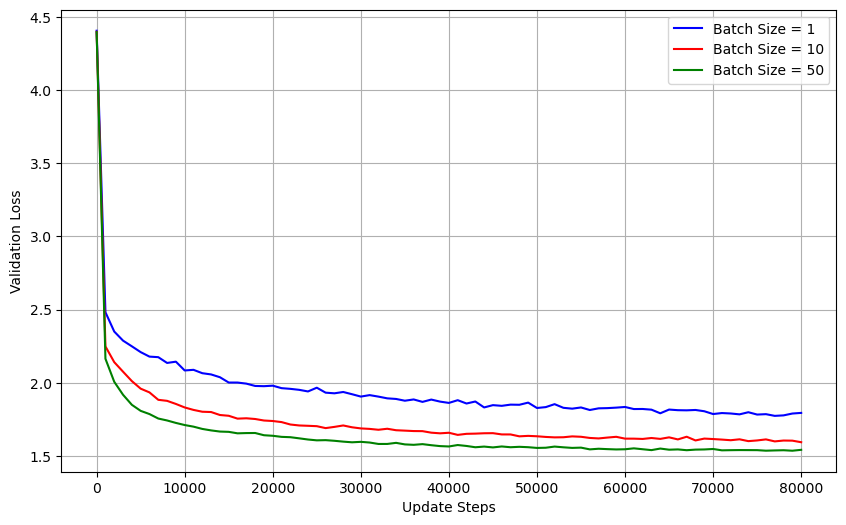

In [327]:
plot_per = 1000
l = len(losses_rd_1)
plt.figure(figsize=(10, 6))
plt.plot(list(range(1, l * plot_per, plot_per)), losses_rd_1, label='Batch Size = 1', color='blue')
plt.plot(list(range(1, l * plot_per, plot_per)), losses_rd_10, label='Batch Size = 10', color='red')
plt.plot(list(range(1, l * plot_per, plot_per)), losses_rd_50, label='Batch Size = 50', color='green')
plt.xlabel('Update Steps')
plt.ylabel('Validation Loss')
plt.grid()
plt.legend()
plt.savefig(f"comparison_random_batch_sizes.png", dpi=300)
plt.show()

3) Temperature and Nucleus sampling:

In [330]:
def synthesize_temperature(RNN, h0, x0, rng, n, ind_to_char, T):
    """
    Synthesize text of length n with temperature-based sampling for a given RNN, an input x0 and a previous hidden state h0.
    """
    b, c = RNN['b'], RNN['c']
    U, W, V = RNN['U'], RNN['W'], RNN['V']
    hprev = h0
    K = x0.shape[0]
    X = []

    x = x0
    for t in range(n):
        a = np.dot(W, hprev) + np.dot(U, x) + b
        hprev = np.tanh(a)
        o = np.dot(V, hprev) + c

        # Apply temperature scaling before softmax
        o = o / T
        p = softmax(o)

        cp = np.cumsum(p, axis=0)
        a = rng.uniform(size=1)
        ii = np.argmax(cp - a > 0)
        x = one_hot(ii, K)
        X.append(ii)  # store the sampled index

    return ''.join(ind_to_char[i] for i in X)

def synthesize_nucleus(RNN, h0, x0, rng, n, ind_to_char, theta):
    """
    Synthesize text of length n with nucleus sampling for a given RNN, an input x0 and a previous hidden state h0.
    """
    b, c = RNN['b'], RNN['c']
    U, W, V = RNN['U'], RNN['W'], RNN['V']
    hprev = h0
    K = x0.shape[0]
    X = []

    x = x0
    for t in range(n):
        a = np.dot(W, hprev) + np.dot(U, x) + b
        hprev = np.tanh(a)
        o = np.dot(V, hprev) + c
        p = softmax(o).flatten()

        # Sort probabilities and get sorted indices
        sorted_indices = np.argsort(p)[::-1]
        sorted_p = p[sorted_indices]

        # Compute the cumulative sum
        cumulative_probs = np.cumsum(sorted_p)

        # Find the top-k_t probabilities where cumulative sum >= theta
        k_t = np.searchsorted(cumulative_probs, theta) + 1

        # Create a new distribution only for top-k_t values
        top_indices = sorted_indices[:k_t]
        top_p = p[top_indices]
        top_p = top_p / top_p.sum()  # renormalize

        # Sample from top-p distribution
        sampled_index = rng.choice(top_indices, p=top_p)
        x = one_hot(sampled_index, K)
        X.append(sampled_index)

    return ''.join(ind_to_char[i] for i in X)

In [370]:
# Synthesize a length 200 text
values = [0.2, 0.5, 0.8]
h0 = np.zeros((m, 1)) # initialize a first zero hidden state
x0 = one_hot(char_to_ind['.'], 83) # initialize a dummmy input
rng = np.random.default_rng(seed=42)
for value in values:
    print(f'\nTemperature Sampling with T={value}:')
    print(synthesize_temperature(RNN_50, h0, x0, rng=rng, n=400, ind_to_char=ind_to_char, T=value))
    print(f'\nNucleus Sampling with theta={value}:')
    print(synthesize_nucleus(RNN_50, h0, x0, rng=rng, n=400, ind_to_char=ind_to_char, theta=value))


Temperature Sampling with T=0.2:
  He was a side of the took before the started to the started to be some on the staring to the contant of the comple a since the started to the continued to the took of the table and the comple started to the could be a side of the moment to the comple starting to the carried to the continued to be a side of the cours of the comple said a stare to the course she was a since the took of the side a 

Nucleus Sampling with theta=0.2:
  He was so that was a stared a look and started to the started to the could be so that was starting a sharping and the started to the could be so that he was a starting to be the started to be a look at the stared a sing the stared to be the could be the took a look and the started to the started to be so had the started to be a sing the course said Harry and the started to the could be so that w

Temperature Sampling with T=0.5:
  He said closed to have complete of a scarent at the cup to the Mad-Eye more and down the pain 